In [1]:
!pip install bitsandbytes>=0.41.3
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets
!pip uninstall torch torchdata -y
!pip install torch==1.13.1
!pip install torchdata==0.5.1
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install bert-score
!pip install ludwig
!pip install nlpaug

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
#bitsandbytes --version

In [3]:
import os
import gc

from google.colab import data_table

import numpy as np
import pandas as pd

import torch
from torch import Tensor

import datasets
from datasets import Dataset, DatasetDict

import yaml
from ludwig.api import LudwigModel, TrainingResults


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Output.csv to Output.csv


In [5]:
import pandas as pd

file_name = "Output.csv"
try:
    # Prova a leggere il file con il delimitatore corretto
    df = pd.read_csv(file_name, delimiter=',', on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error parsing CSV file: {e}")

# Visualizza le prime righe del dataset
print(df.head())

                                             DOMANDE  \
0  Ho avuto un breve affanno dopo una passeggiata...   
1  Dovrei essere preoccupato se ho sperimentato u...   
2  Dovrei essere preoccupato se ho avuto un legge...   
3  È motivo di preoccupazione se ho avuto un brev...   
4  Dovrei essere preoccupato se ho avuto un po' d...   

                                            RISPOSTE  
0  Capisco che possa essere preoccupante, ma un b...  
1  È comprensibile essere preoccupati per un epis...  
2  L'affanno dopo una camminata può essere normal...  
3  È comprensibile essere preoccupati per un brev...  
4  L'affanno dopo una passeggiata può essere norm...  


Skipping line 35: expected 2 fields, saw 3



##MIGLIORAMENTO PRE-FINETUNING:
1. Pulizia Avanzata dei Dati:
Rimuovi o correggi i dati rumorosi o anomali nel dataset.
Normalizza i testi, ad esempio, convertendo tutto in minuscolo e rimuovendo i caratteri speciali non necessari.

2. Bilanciamento del Dataset:
Assicurati che il dataset abbia una distribuzione bilanciata di domande e risposte per evitare bias.

3. Augmentazione dei Dati:
Utilizza tecniche di augmentazione come la parafrasi automatica per generare più dati di addestramento.

In [6]:
# Pulizia del dataset
df_cleaned = df.dropna()

In [7]:
from transformers import AutoTokenizer
# Funzione per calcolare la lunghezza media delle domande e delle risposte in token
def calculate_average_length(df, question_col, answer_col, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenizzazione e calcolo delle lunghezze
    df['question_length'] = df[question_col].apply(lambda x: len(tokenizer.tokenize(x)))
    df['answer_length'] = df[answer_col].apply(lambda x: len(tokenizer.tokenize(x)))

    # Calcolo della lunghezza media
    avg_question_length = df['question_length'].mean()
    avg_answer_length = df['answer_length'].mean()

    return avg_question_length, avg_answer_length

In [8]:
from sklearn.utils import resample
import nlpaug.augmenter.word as naw

# Bilanciamento del dataset
min_class_size = df_cleaned['DOMANDE'].value_counts().min()
df_balanced = df_cleaned.groupby('DOMANDE').apply(lambda x: resample(x, replace=False, n_samples=min_class_size)).reset_index(drop=True)

# Augmentazione dei dati
aug = naw.SynonymAug(aug_src='wordnet')

df_balanced['DOMANDE_aug'] = df_balanced['DOMANDE'].apply(lambda x: aug.augment(x))
df_balanced['RISPOSTE_aug'] = df_balanced['RISPOSTE'].apply(lambda x: aug.augment(x))

df_augmented = pd.concat([df_balanced[['DOMANDE', 'RISPOSTE']],
                          df_balanced[['DOMANDE_aug', 'RISPOSTE_aug']].rename(columns={'DOMANDE_aug': 'DOMANDE', 'RISPOSTE_aug': 'RISPOSTE'})])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [9]:
df_augmented['DOMANDE'] = df_augmented['DOMANDE'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df_augmented['RISPOSTE'] = df_augmented['RISPOSTE'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

In [10]:
#suddivisione del set di dati in un set di addestramento, in uno di test e in uno di validazione
from sklearn.model_selection import train_test_split

#separo le caratteristiche dal target (divido input da output)
df_train, df_temp = train_test_split(df_augmented, test_size=0.4, random_state=200)
df_test, df_validation = train_test_split(df_temp, test_size=0.5, random_state=200)

In [11]:
# Verifica delle dimensioni
print(f'Train set size: {df_train.shape}')
print(f'Test set size: {df_test.shape}')
print(f'Validation set size: {df_validation.shape}')

Train set size: (1720, 2)
Test set size: (574, 2)
Validation set size: (574, 2)


In [12]:
# Aggiungere una colonna per indicare lo split (per indicare quale riga appartiene a quale suddivisione.)
df_train["split"] = np.zeros(df_train.shape[0])
df_test["split"] = np.ones(df_test.shape[0])
df_validation["split"] = np.full(df_validation.shape[0], 2)

df_dataset = pd.concat([df_train, df_test, df_validation])
df_dataset["split"] = df_dataset["split"].astype(int)

# Verifica delle dimensioni complessive
print(df_dataset.shape)

(2868, 3)


In [13]:
# Verifica delle dimensioni per ciascuno split
assert df_dataset[df_dataset["split"] == 0].shape[0] == df_train.shape[0]
assert df_dataset[df_dataset["split"] == 1].shape[0] == df_test.shape[0]
assert df_dataset[df_dataset["split"] == 2].shape[0] == df_validation.shape[0]

La media del numero di token nella colonna DOMANDE è: 24
La media del numero di token nella colonna RISPOSTE è: 81


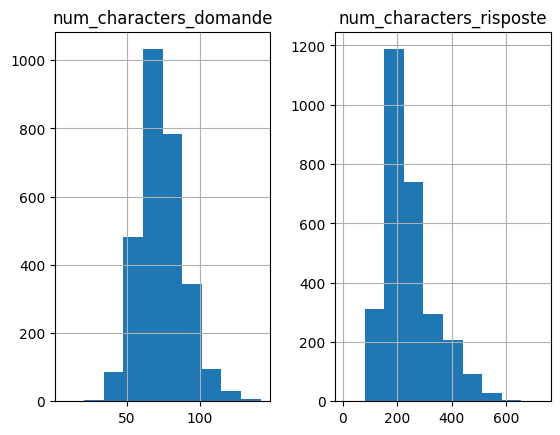

In [14]:
# Calcolare la lunghezza dei caratteri in ciascuna colonna
df_dataset['num_characters_domande'] = df_dataset['DOMANDE'].apply(lambda x: len(str(x)))
df_dataset['num_characters_risposte'] = df_dataset['RISPOSTE'].apply(lambda x: len(str(x)))

# Visualizzare la distribuzione
df_dataset.hist(column=['num_characters_domande', 'num_characters_risposte'])

# Calcolare la media
average_chars_domande = df_dataset['num_characters_domande'].mean()
average_chars_risposte = df_dataset['num_characters_risposte'].mean()

print(f'La media del numero di token nella colonna DOMANDE è: {(average_chars_domande / 3):.0f}')
print(f'La media del numero di token nella colonna RISPOSTE è: {(average_chars_risposte / 3):.0f}')

##Cos'è la Regolarizzazione?
La regolarizzazione è una tecnica utilizzata durante l'addestramento dei modelli di machine learning per prevenire l'overfitting. L'overfitting si verifica quando un modello impara troppo bene i dettagli e il rumore nel dataset di addestramento, perdendo la capacità di generalizzare su nuovi dati. La regolarizzazione aggiunge una penalità per la complessità del modello, aiutando a mantenere il modello più semplice e a migliorare la sua capacità di generalizzare.

**Dropout:**

Dropout è una tecnica di regolarizzazione specificamente utilizzata nelle reti neurali. Durante l'addestramento, il Dropout spegne (esclude) casualmente una frazione di neuroni nel modello a ogni iterazione. Questo impedisce ai neuroni di diventare troppo dipendenti dagli altri neuroni, migliorando la capacità di generalizzazione del modello. Durante l'inferenza (valutazione o previsione), tutti i neuroni sono attivi e i pesi dei neuroni sono scalati per tenere conto del Dropout.

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Percorso alla cartella del modello salvato
model_path: str = "BioMistral/BioMistral-7B"

# Carica il tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    model_max_length=512,
    trust_remote_code=True,
    padding_side="left",
    add_eos_token=True)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)


model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder="offload", # Offload di parti del modello sulla CPU
    trust_remote_code=True,
    low_cpu_mem_usage=True,
   quantization_config=bnb_config
)


tokenizer_config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.5G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [16]:
from google.colab import drive
drive.mount('/content/drive')

# Definisci il percorso di output per Google Colab
output_dir = "/content/drive/My Drive/BERT_SCORE_RESULTS_LUDWIG"
responses_filename_pre = "pre_fine_tuning_responses.xlsx"
scores_filename_pre = "pre_fine_tuning_scores.xlsx"
responses_filename_post = "post_fine_tuning_responses.xlsx"
scores_filename_post = "post_fine_tuning_scores.xlsx"

# Assicurati che la directory di output esista
os.makedirs(output_dir, exist_ok=True)

Mounted at /content/drive


In [17]:
# Estrazione di 150 domande casuali dal DataFrame originale
#eval_df = df_test[['DOMANDE', 'RISPOSTE']]
#eval_df = df_test.sample(n=150, random_state=42)

# Calcola la metà del numero totale di righe
#num_rows = len(df_test)
#half_num_rows = num_rows // 2  # Usa // per ottenere un numero intero
eval_df = df_test[['DOMANDE', 'RISPOSTE']]
# Estrai un campione casuale di metà delle righe dal DataFrame
eval_df = df_test.sample(n=80, random_state=42)

# Estrai le risposte di riferimento
reference_responses = eval_df['RISPOSTE'].tolist()

In [18]:
#Funzione per assicurarsi che le frasi termino con u punto
def ensure_ending_with_period(response):
    response = response.strip()
    if not response.endswith('.'):
       response += '.'
    return response

In [19]:
prompt_template: str = """
    Sei un esperto cardiologo. Rispondi alla seguente domanda in modo empatico e con frasi complete e concise, terminando ogni frase con un punto.
    ### Esempio 1:
    Domanda: Quali sono i sintomi dell'ipertensione?
    Risposta: I sintomi dell'ipertensione includono mal di testa, vertigini e difficoltà respiratorie.
    ### Esempio 2:
    Domanda: Come posso controllare la mia pressione arteriosa?
    Risposta: Puoi controllare la tua pressione arteriosa con una dieta sana, esercizio fisico regolare e farmaci prescritti.
    ### Domanda: {DOMANDE}
    ### Risposta (Assicurati che la tua risposta termini con un punto e abbia senso compiuto):
"""

In [20]:
from transformers import pipeline

# Funzione per generare risposte e calcolare BERTScore
def generate_responses_pre_finetuning(model, tokenizer, eval_df):
  #PROVO CON LA PIPELINE DI GENERAZIONE TESTO (Creo la pipeline di generazione)
  response_generator = pipeline(
      task="text-generation",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.float16,
      device_map="auto"
  )

  # Genera e stampa la risposta per le prime 10 domande
  generated_responses = []
  for index, row in eval_df.iterrows():
    domande_test = row['DOMANDE']
    print(f'Generating response for question {index + 1}/{len(eval_df)}: {domande_test}')
    test_prompt = prompt_template.format(DOMANDE=domande_test)
    try:
      responses = response_generator(
          text_inputs=test_prompt,
          do_sample=True,
          top_k=50,
          num_return_sequences=1,
          eos_token_id=tokenizer.eos_token_id,
          max_length=512,
          truncation=True,
          #return_text=True
      )
      # Estrai e stampa la risposta generata
      generated_response = responses[0]['generated_text']
      generated_response = ensure_ending_with_period(generated_response)
      generated_responses.append(generated_response)
    except Exception as e:
      print(f"Error generating response for question {index + 1}: {e}")
    print(f"Generated {len(generated_responses)} responses out of {len(eval_df)} expected.")
  return generated_responses

In [21]:
# Funzione per salvare le risposte generate e originali
def save_responses(responses, reference_responses, questions, output_dir, filename):
    df = pd.DataFrame({
        'DOMANDE': questions,
        'RISPOSTE_GENERATE': responses,
        'RISPOSTE_ORIGINALI': reference_responses
    })
    output_path = os.path.join(output_dir, filename)
    df.to_excel(output_path, index=False,  engine='openpyxl')
    return output_path

# Funzione per salvare i punteggi BERTScore
def save_scores(P, R, F1, output_dir, filename):
    # Calcolo della media dei punteggi
    mean_P = sum(P) / len(P)
    mean_R = sum(R) / len(R)
    mean_F1 = sum(F1) / len(F1)

    df = pd.DataFrame({
        'Precision': P,
        'Recall': R,
        'F1': F1,
        'Mean Precision': [mean_P] * len(P),
        'Mean Recall': [mean_R] * len(R),
        'Mean F1': [mean_F1] * len(F1)
    })
    output_path = os.path.join(output_dir, filename)
    df.to_excel(output_path, index=False,  engine='openpyxl')
    return output_path

In [22]:
# Genera le risposte con il modello pre-addestrato
print("Generating responses with the pre-fine-tuning model...")
generated_responses_pre = generate_responses_pre_finetuning(model, tokenizer, eval_df)

Generating responses with the pre-fine-tuning model...
Generating response for question 357/80: Il fatto che alcuni miei familiari soffrano di ipertensione incrementa il mio rischio di sviluppare questa condizione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 1 responses out of 80 expected.
Generating response for question 580/80: Liter ' ipertensione può avere un impatto lucius cornelius sulla felix mia capacità di concentrarmi?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 2 responses out of 80 expected.
Generating response for question 1109/80: Quali problemi di salute possono insorgere se 50 ' ipertensione non viene gestita?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 3 responses out of 80 expected.
Generating response for question 1265/80: Quali sono le principali cause dingle ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 4 responses out of 80 expected.
Generating response for question 381/80: In che modo i geni possono aumentare il rischio di sviluppare il cancro?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 5 responses out of 80 expected.
Generating response for question 853/80: Qual è il modo migliore per annotare i sintomi che avverto oggi?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 6 responses out of 80 expected.
Generating response for question 5/80: Alcune razze hanno un rischio più alto di sviluppare malattie cardiache?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 7 responses out of 80 expected.
Generating response for question 611/80: L'ipertensione può influenzare le mie attività quotidiane?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 8 responses out of 80 expected.
Generating response for question 607/80: L ' ipertensione può essere una conseguenza diretta della mia depressione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 9 responses out of 80 expected.
Generating response for question 53/80: Che relazione esiste tra il diabete einsteinium litre ' ipertensione?


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 10 responses out of 80 expected.
Generating response for question 768/80: Potresti spiegare in cosa si distinguono l'ipertensione primaria e quella secondaria?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 11 responses out of 80 expected.
Generating response for question 772/80: Potresti spiegarmi cosa significa avere la pressione alta?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 12 responses out of 80 expected.
Generating response for question 68/80: Che suggerimenti puoi darmi riguardo alla mia ipertensione di oggi?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 13 responses out of 80 expected.
Generating response for question 574/80: L'ipertensione può avere effetti sulla mia capacità di mantenere la concentrazione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 14 responses out of 80 expected.
Generating response for question 884/80: Qual è la correlazione tra il diabete e la pressione alta?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 15 responses out of 80 expected.
Generating response for question 958/80: Quali complicazioni oculari sono associate alla pressione alta?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 16 responses out of 80 expected.
Generating response for question 67/80: Che suggerimenti puoi darmi per affrontare più efficacemente lah mia ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 17 responses out of 80 expected.
Generating response for question 1201/80: Quali sono i motivi per cui la mia pressione sanguigna potrebbe essere instabile?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 18 responses out of 80 expected.
Generating response for question 543/80: L ' alta pressione sanguigna può portare allo sviluppo di altre patologie?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 19 responses out of 80 expected.
Generating response for question 1347/80: Vorrei gestire anche oggi lah mia ipertensione.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 20 responses out of 80 expected.
Generating response for question 1028/80: Quali informazioni puoi fornirmi sui monitoraggi per l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 21 responses out of 80 expected.
Generating response for question 1213/80: Quali sono i rischi associati all'ipertensione non trattata?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 22 responses out of 80 expected.
Generating response for question 724/80: Lo yoga è efficace per ridurre l ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 23 responses out of 80 expected.
Generating response for question 873/80: Qual è l'impatto dello stress sull'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 24 responses out of 80 expected.
Generating response for question 112/80: Come influisce lo stress sui valori della pressione sanguigna?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 25 responses out of 80 expected.
Generating response for question 91/80: Curie sono effetti a lungo termine dingle ' ipertensione non trattata?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 26 responses out of 80 expected.
Generating response for question 249/80: Dovrei preoccuparmi se la pressione sanguigna è elevata solo occasionalmente?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 27 responses out of 80 expected.
Generating response for question 39/80: Che dispositivi posso utilizzare per monitorare e registrare la mia frequenza cardiaca?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 28 responses out of 80 expected.
Generating response for question 104/80: Come il colesterolo può influenzare l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 29 responses out of 80 expected.
Generating response for question 1161/80: Quali sono i fattori che provocano l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 30 responses out of 80 expected.
Generating response for question 189/80: Come si può definire 50 ' ipertensione in termini medici?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 31 responses out of 80 expected.
Generating response for question 302/80: Esistono segnali di avvertimento che suggeriscono un ' ipertensione non ben gestita?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 32 responses out of 80 expected.
Generating response for question 778/80: Puoi chiarire in che modo louisiana pressione alta può incidere sul mio benessere?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 33 responses out of 80 expected.
Generating response for question 366/80: Prairie state rischio di malattie cardiache è differente tra le varie etnie?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 34 responses out of 80 expected.
Generating response for question 824/80: Può la musica contribuire a ridurre litre ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 35 responses out of 80 expected.
Generating response for question 1075/80: Quali modifiche aluminum proprio stile di vita possono contribuire a gestire l ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 36 responses out of 80 expected.
Generating response for question 1311/80: Quali tepee di attività fisica sono consigliati per alleviare lo tension legato all ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 37 responses out of 80 expected.
Generating response for question 1198/80: Quali sono i modi per ridurre land of lincoln rischio di malattie cardiache?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 38 responses out of 80 expected.
Generating response for question 644/80: La depressione può influire o essere influenzata dall'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 39 responses out of 80 expected.
Generating response for question 1359/80: È motivo di preoccupazione southeastward atomic number 67 avuto un breve affanno dopo una camminata?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 40 responses out of 80 expected.
Generating response for question 21/80: C'è una correlazione tra l'invecchiamento e l'aumento della pressione arteriosa?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 41 responses out of 80 expected.
Generating response for question 151/80: Come posso gestire efficacemente la mia ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 42 responses out of 80 expected.
Generating response for question 719/80: Lo yoga può essere utile per ridurre l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 43 responses out of 80 expected.
Generating response for question 183/80: Come si distinguono l'ipertensione primaria e quella secondaria?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 44 responses out of 80 expected.
Generating response for question 472/80: In che modo lah pressione alta può incidere sulle mie attività quotidiane?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 45 responses out of 80 expected.
Generating response for question 996/80: Quali effetti può avere l ' ipertensione sulla vista?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 46 responses out of 80 expected.
Generating response for question 1369/80: È possibile annotare i dati relativi alla mia frequenza cardiaca?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 47 responses out of 80 expected.
Generating response for question 1339/80: Sono preoccupato perché la mia pressione arteriosa è stata variabile di recente. Quali sono ace passi che posso seguire?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 48 responses out of 80 expected.
Generating response for question 1163/80: Quali sono one livelli standard della pressione sanguigna?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 49 responses out of 80 expected.
Generating response for question 331/80: Gli integratori naturali possono essere utili per abbassare la pressione arteriosa?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 50 responses out of 80 expected.
Generating response for question 1380/80: È possibile che l'ipertensione provochi complicazioni durante la gravidanza?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 51 responses out of 80 expected.
Generating response for question 581/80: Lambert ' ipertensione può avere un impatto sulla mia capacità di concentrazione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 52 responses out of 80 expected.
Generating response for question 717/80: Lo yoga può essere utile nel trattare l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 53 responses out of 80 expected.
Generating response for question 901/80: Quale impatto può avere l ' ambiente di lavoro sull ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 54 responses out of 80 expected.
Generating response for question 1054/80: Quali metodi posso utilizzare per diminuire le probabilità di sviluppare ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 55 responses out of 80 expected.
Generating response for question 915/80: Quali alimenti sarebbe meglio non consumare in caso di ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 56 responses out of 80 expected.
Generating response for question 1383/80: È possibile che l ' ipertensione provochi mal di episperm ricorrenti?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 57 responses out of 80 expected.
Generating response for question 1122/80: Quali segnali indicano la presenza di depressione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 58 responses out of 80 expected.
Generating response for question 588/80: L'ipertensione può causare complicazioni oculari?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 59 responses out of 80 expected.
Generating response for question 658/80: La mia pressione arteriosa elevata può influenzare la mia scene?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 60 responses out of 80 expected.
Generating response for question 888/80: Qual è louisiana posizione migliore per misurare louisiana pressione arteriosa?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 61 responses out of 80 expected.
Generating response for question 140/80: Come posso annotare 1 sintomi che ho avuto oggi?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 62 responses out of 80 expected.
Generating response for question 1325/80: Quanto è rilevante monitorare costantemente fifty ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 63 responses out of 80 expected.
Generating response for question 827/80: Qual è il legame tra età avanzata e rischio di ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 64 responses out of 80 expected.
Generating response for question 677/80: La pressione alta può avere un impatto lucius cornelius sulla felix funzione dei reni?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 65 responses out of 80 expected.
Generating response for question 1131/80: Quali sintomi dovrei tenere d'occhio per riconoscere l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 66 responses out of 80 expected.
Generating response for question 83/80: Che tipo di supporto posso cercare per superare l ' ansia legata all ' ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 67 responses out of 80 expected.
Generating response for question 1050/80: Quali metodi posso usare per monitorare correttamente i dati della frequenza cardiaca?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 68 responses out of 80 expected.
Generating response for question 575/80: Lambert ' ipertensione può avere effetti sulla salute dei reni?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 69 responses out of 80 expected.
Generating response for question 1287/80: Quali strumenti posso usare per registrare i sintomi che avverto?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 70 responses out of 80 expected.
Generating response for question 526/80: In che modo si identifica l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 71 responses out of 80 expected.
Generating response for question 747/80: Posso registrare i dati della mia frequenza cardiaca?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 72 responses out of 80 expected.
Generating response for question 762/80: Potresti elencare i pericoli legati alla mancata cura dell'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 73 responses out of 80 expected.
Generating response for question 34/80: Che cos'è l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 74 responses out of 80 expected.
Generating response for question 1240/80: Quali sono le cause che possono determinare un improvviso aumento della pressione arteriosa?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 75 responses out of 80 expected.
Generating response for question 1116/80: Quali rischi comporta l'ipertensione nel corso della gravidanza?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 76 responses out of 80 expected.
Generating response for question 1203/80: Quali sono i parametri standard della pressione sanguigna?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 77 responses out of 80 expected.
Generating response for question 1162/80: Quali sono iodine livelli considerati normali per la pressione sanguigna?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 78 responses out of 80 expected.
Generating response for question 201/80: Con quale frequenza è consigliabile monitorare la pressione sanguigna?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated 79 responses out of 80 expected.
Generating response for question 296/80: Esistono prove scientifiche che lo yoga sia efficace per ridurre atomic number 57 pressione arteriosa?
Generated 80 responses out of 80 expected.


In [23]:
# Visualizzazione delle prime 5 domande e risposte pre-fine-tuning
print("\nFirst 5 pre-fine-tuning responses:")
print(pd.DataFrame({'DOMANDA': eval_df['DOMANDE'], 'RISPOSTA_GENERATA': generated_responses_pre}).head(5))


First 5 pre-fine-tuning responses:
                                                DOMANDA  \
356   Il fatto che alcuni miei familiari soffrano di...   
579   Liter ' ipertensione può avere un impatto luci...   
1108  Quali problemi di salute possono insorgere se ...   
1264  Quali sono le principali cause dingle ' iperte...   
380   In che modo i geni possono aumentare il rischi...   

                                      RISPOSTA_GENERATA  
356   Sei un esperto cardiologo. Rispondi alla segue...  
579   Sei un esperto cardiologo. Rispondi alla segue...  
1108  Sei un esperto cardiologo. Rispondi alla segue...  
1264  Sei un esperto cardiologo. Rispondi alla segue...  
380   Sei un esperto cardiologo. Rispondi alla segue...  


In [24]:
from bert_score import score
# Calcola BERTScore per il modello pre-addestrato
print("Evaluating BERTScore for the pre-fine-tuning model...")
P_pre, R_pre, F1_pre = score(generated_responses_pre, reference_responses, lang="it", verbose=True)


Evaluating BERTScore for the pre-fine-tuning model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 3.18 seconds, 25.19 sentences/sec


In [25]:
# Converti i tensori PyTorch in array NumPy, se necessario
if isinstance(P_pre, torch.Tensor):
    P_pre = P_pre.numpy()
if isinstance(R_pre, torch.Tensor):
    R_pre = R_pre.numpy()
if isinstance(F1_pre, torch.Tensor):
    F1_pre = F1_pre.numpy()

# Stampa i punteggi medi
print(f'Mean Precision: {np.mean(P_pre):.4f}')
print(f'Mean Recall: {np.mean(R_pre):.4f}')
print(f'Mean F1: {np.mean(F1_pre):.4f}')

Mean Precision: 0.5740
Mean Recall: 0.6794
Mean F1: 0.6220


In [26]:
# Salvataggio delle risposte pre-fine-tuning
output_responses_pre = save_responses(generated_responses_pre, reference_responses, eval_df['DOMANDE'], output_dir, responses_filename_pre)
# Salvataggio dei punteggi pre-fine-tuning
output_scores_pre = save_scores(P_pre, R_pre, F1_pre, output_dir, scores_filename_pre)

In [27]:
model.gradient_checkpointing_enable()
# Free up memory
torch.cuda.empty_cache()
gc.collect()

1122

In [28]:
yaml_config_template = """
model_type: llm
base_model: {model_path}

input_features:
  - name: DOMANDE
    type: text
    preprocessing:
      truncation: true
      max_sequence_length: 210
      lowercase: true

output_features:
  - name: RISPOSTE
    type: text
    preprocessing:
      max_sequence_length: 1000
      max_length: 1000
      truncation: true
    metrics:
      - type: bert_score
        model: dbmdz/bert-base-italian-uncased
      - type: loss
      ### - type: rouge, - type: perplexity

prompt:
  template: >-
    Sei un esperto cardiologo. Rispondi alla seguente domanda in modo empatico e con frasi complete e concise, terminando ogni frase con un punto.
    ### Esempio 1:
    Domanda: Quali sono i sintomi dell'ipertensione?
    Risposta: I sintomi dell'ipertensione includono mal di testa, vertigini e difficoltà respiratorie.
    ### Esempio 2:
    Domanda: Come posso controllare la mia pressione arteriosa?
    Risposta: Puoi controllare la tua pressione arteriosa con una dieta sana, esercizio fisico regolare e farmaci prescritti.
    ### Domanda: {DOMANDE}
    ### Risposta (Assicurati che la tua risposta termini con un punto e abbia senso compiuto):

generation:
  temperature: 0.1    ### per la generazione del testo deve essere molto basso
  max_new_tokens: 80
  top_p: 0.9          ### aiuta a generare testo più coerente e fluido. , il modello avrà un equilibrio tra casualità e coerenza, garantendo che i token generati siano tra quelli con le probabilità più alte.

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  split:
    type: random
    probabilities: [0.8, 0.1, 0.1]  ### a gestione di più sottoinsiemi può richiedere risorse aggiuntive.
  global_max_sequence_length: 1210

trainer:
  type: finetune
  epochs: 4
  batch_size: 2
  eval_batch_size: 2
  gradient_accumulation_steps: 8  # effective batch size = batch size * gradient_accumulation_steps
  learning_rate: 1.0e-4  # Prova con un learning rate leggermente più basso
  enable_gradient_checkpointing: true
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.1  # Aumenta il warmup fraction
    reduce_on_plateau: 0

### un checkpoint del modello verrà salvato ogni 500 step di addestramento, permettendo il ripristino del modello in caso di interruzioni.
early_stopping:                             ### monitora la perdita di validazione (val_loss) e interrompe l'addestramento se la perdita non migliora per 5 epoche consecutive, per prevenire l'overfitting (min: il monitoraggio è configurato per minimizzare la perdita).
  monitor: val_loss
  patience: 5
  mode: min

logging:                                    ### i log dell'allenamento verranno inviati a TensorBoard.
  log_to_tensorboard: true

callbacks:
  - type: progress_bar
  - type: model_checkpoint
    save_best_only: true
    monitor: val_loss
    mode: min
  - type: early_stopping
    monitor: val_loss
    patience: 5
    mode: min
"""

In [29]:
# Sostituisci solo il segnaposto {model_path}
yaml_config = yaml_config_template.replace("{model_path}", model_path)

# Carica la configurazione YAML come dizionario
qlora_fine_tuning_config = yaml.safe_load(yaml_config)


In [30]:
# Inizializza il modello Ludwig con la configurazione aggiornata
model_ludwig = LudwigModel(config=qlora_fine_tuning_config)

In [31]:
# Esegui il fine-tuning del modello con Ludwig
train_stats, eval_stats, output_dir = model_ludwig.train(dataset=df_train)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342:

In [32]:
#results: TrainingResults = model.train(dataset=df_dataset)

In [33]:
#Lo salvo e lo ricarico per eseguirlo
# Salva il modello
model_ludwig.save("FineTuned_Biomistral_Ludwig")

In [34]:
# Carica il modello salvato
model_loaded = LudwigModel.load("FineTuned_Biomistral_Ludwig")

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [35]:
from bert_score import score

# Funzione per generare risposte e calcolare BERTScore
def generate_responses_post_finetuning(model, eval_df):
    # Ottieni le previsioni dal modello
    predictions_df = model.predict(dataset=eval_df)

    # Se predictions_df è una tupla, ottieni il DataFrame delle previsioni
    if isinstance(predictions_df, tuple):
        predictions_df = predictions_df[0]

    # Verifica se il DataFrame predictions contiene la colonna 'RISPOSTE_response'
    if 'RISPOSTE_response' in predictions_df.columns:
        # Estrai le risposte generate
        generated_responses = predictions_df['RISPOSTE_response'].apply(lambda x: ''.join(x) if isinstance(x, list) else x).tolist()

        for domanda, risposta in zip(eval_df['DOMANDE'], generated_responses):
            print(f'\n[DOMANDA]: {domanda}\n[GENERATED_TEXT] MODEL_PREDICTION:\n{risposta}\n')
        return generated_responses
    else:
        raise ValueError("La colonna 'RISPOSTE_response' non è presente nel DataFrame delle previsioni.")


In [36]:
# Genera le risposte con il modello fine-tunato
print("Generating responses with the post-fine-tuning model...")
generated_responses_post = generate_responses_post_finetuning(model_loaded, eval_df)


Generating responses with the post-fine-tuning model...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



[DOMANDA]: Il fatto che alcuni miei familiari soffrano di ipertensione incrementa il mio rischio di sviluppare questa condizione?
[GENERATED_TEXT] MODEL_PREDICTION:
Sì, avere familiari con ipertensione può aumentare il tuo rischio di sviluppare questa condizione, poiché la genetica può giocare un ruolo importante. Tuttavia, è importante tenere in considerazione fattori come lo stile di vita, l'alimentazione e l'attività fis


[DOMANDA]: Liter ' ipertensione può avere un impatto lucius cornelius sulla felix mia capacità di concentrarmi?
[GENERATED_TEXT] MODEL_PREDICTION:
Sì, l ' ipertensione può influenzare la capacità di concentrarsi, poiché la pressione alta può causare affaticamento e stanchezza, rendendo difficile concentrarsi su una tarea specifica.


[DOMANDA]: Quali problemi di salute possono insorgere se 50 ' ipertensione non viene gestita?
[GENERATED_TEXT] MODEL_PREDICTION:
Se l ' ipertensione non viene gestita, può portare a gravi problemi di salute come danni agli occhi, al 

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [37]:
from bert_score import score
# Calcola BERTScore per il modello fine-tunato
print("Evaluating BERTScore for the post-fine-tuning model...")
P_post, R_post, F1_post = score(generated_responses_post, reference_responses, lang="it", verbose=True)
print(f"Post-fine-tuning BERTScore - Precision: {P_post.mean().item()}, Recall: {R_post.mean().item()}, F1: {F1_post.mean().item()}")

Evaluating BERTScore for the post-fine-tuning model...


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.97 seconds, 82.87 sentences/sec
Post-fine-tuning BERTScore - Precision: 0.817977249622345, Recall: 0.7954052686691284, F1: 0.8059874773025513


In [38]:
# Visualizzazione delle prime 5 domande e risposte post-fine-tuning
print("\nFirst 5 post-fine-tuning responses:")
print(pd.DataFrame({'DOMANDA': eval_df['DOMANDE'], 'RISPOSTA_GENERATA': generated_responses_post}).head(5))


First 5 post-fine-tuning responses:
                                                DOMANDA  \
356   Il fatto che alcuni miei familiari soffrano di...   
579   Liter ' ipertensione può avere un impatto luci...   
1108  Quali problemi di salute possono insorgere se ...   
1264  Quali sono le principali cause dingle ' iperte...   
380   In che modo i geni possono aumentare il rischi...   

                                      RISPOSTA_GENERATA  
356   Sì, avere familiari con ipertensione può aumen...  
579   Sì, l ' ipertensione può influenzare la capaci...  
1108  Se l ' ipertensione non viene gestita, può por...  
1264  La ' ipertensione può essere causata da fattor...  
380   I geni possono influenzare il rischio di svilu...  


Viene creato un campione di dati da valutare (df_evaluation). Il modello fa previsioni su questo campione e il risultato è una tupla che contiene due DataFrame: uno con le previsioni (df_predictions) e uno con le probabilità associate a queste previsioni.

#### PREDICTION

#####Verifica delle Previsioni

* **RISPOSTE_predictions:** le previsioni fatte dal modello. Aiuta a capire quale risposta il modello ha generato per un dato input. Può essere utile per analizzare il comportamento del modello su diverse domande o input.
* **RISPOSTE_probabilities:** le probabilità associate a ciascuna previsione.
Fornisce un'idea di quanto il modello sia sicuro delle sue risposte. Può essere utile per identificare risposte su cui il modello ha bassa confidenza e che potrebbero richiedere una revisione o un miglioramento del modello.
* **RISPOSTE_response:** la risposta generata dal modello. È la risposta che sarà presentata all'utente finale. È utile per valutare direttamente la qualità delle risposte generate dal modello e confrontarle con le risposte di riferimento.
* **RISPOSTE_probability:** la probabilità complessiva della risposta generata, che può essere un'aggregazione delle probabilità delle singole parole nella risposta. Può essere usata per filtrare risposte con bassa confidenza o per segnalare risposte che potrebbero necessitare di una verifica manuale.

In [39]:
# Converti i tensori PyTorch in array NumPy, se necessario
if isinstance(P_post, torch.Tensor):
    P = P_post.numpy()
if isinstance(R_post, torch.Tensor):
    R = R_post.numpy()
if isinstance(F1_post, torch.Tensor):
    F1 = F1_post.numpy()

# Stampa i punteggi medi
print(f'Mean Precision: {np.mean(P):.4f}')
print(f'Mean Recall: {np.mean(R):.4f}')
print(f'Mean F1: {np.mean(F1):.4f}')

Mean Precision: 0.8180
Mean Recall: 0.7954
Mean F1: 0.8060


In [40]:
# Salvataggio delle risposte post-fine-tuning
output_responses_post = save_responses(generated_responses_post, reference_responses, eval_df['DOMANDE'], output_dir, responses_filename_post)
# Salvataggio dei punteggi post-fine-tuning
output_scores_post = save_scores(P_post, R_post, F1_post, output_dir, scores_filename_post)

In [41]:
from zipfile import ZipFile
from google.colab import files

# Comprimi i file CSV in un file ZIP
zip_filename = "/content/bert_score_result.zip"
with ZipFile(zip_filename, 'w') as zipf:
    #zipf.write(output_path_pre, os.path.basename(output_path_pre))
    #zipf.write(output_path_post, os.path.basename(output_path_post))
    zipf.write(output_responses_pre, os.path.basename(output_responses_pre))
    zipf.write(output_scores_pre, os.path.basename(output_scores_pre))
    zipf.write(output_responses_post, os.path.basename(output_responses_post))
    zipf.write(output_scores_post, os.path.basename(output_scores_post))

print(f"Files compressed to: {zip_filename}")

# Scarica il file ZIP
files.download(zip_filename)

Files compressed to: /content/bert_score_result.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# Ottieni le previsioni dal modello
df_pred = model_loaded.predict(dataset=eval_df)

# Se df_pred è una tupla, ottieni il DataFrame delle previsioni
if isinstance(df_pred, tuple):
   df_pred = df_pred[0]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [43]:
import subprocess
# Avvia TensorBoard in background
subprocess.Popen(['tensorboard', '--logdir', 'results'])

<Popen: returncode: None args: ['tensorboard', '--logdir', 'results']>

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import json

# Carica i dati del log
log_path = 'results/api_experiment_run/training_statistics.json'

with open(log_path, 'r') as f:
    log_data = json.load(f)

# Verifica la struttura dei dati
print(json.dumps(log_data, indent=2))

{
  "evaluation_frequency": {
    "frequency": 1,
    "period": "epoch"
  },
  "test": {
    "RISPOSTE": {
      "loss": [
        1.0837833881378174,
        0.9657649397850037,
        0.8960124254226685,
        0.8564839959144592
      ],
      "next_token_perplexity": [
        16336.0029296875,
        15943.580078125,
        15571.94921875,
        15481.453125
      ],
      "perplexity": [
        31985.5703125,
        31986.548828125,
        31987.951171875,
        31986.2734375
      ],
      "sequence_accuracy": [
        0.0,
        0.0,
        0.0,
        0.0
      ],
      "token_accuracy": [
        0.00013728217163588852,
        5.973558290861547e-05,
        7.62845593271777e-05,
        0.0001416226732544601
      ]
    },
    "combined": {
      "loss": [
        1.0837833881378174,
        0.9657649397850037,
        0.8960124254226685,
        0.8564839959144592
      ]
    }
  },
  "training": {
    "RISPOSTE": {
      "loss": [
        1.4494439363479614

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (2,).

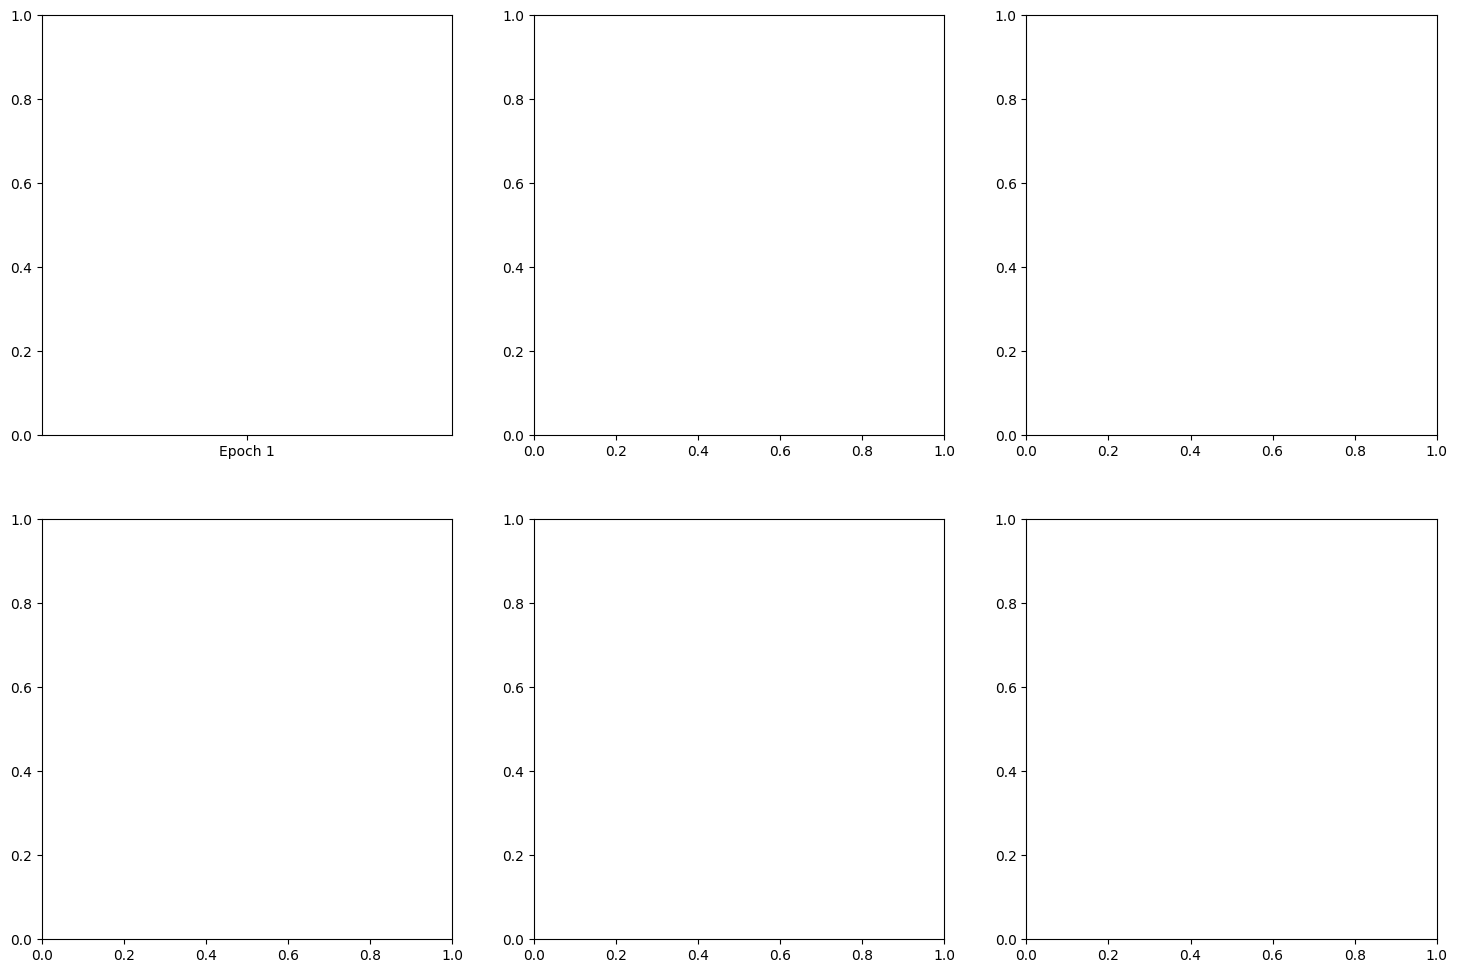

In [45]:
# Estrazione dei dati
train_loss = log_data["training"]["RISPOSTE"]["loss"]
val_loss = log_data["validation"]["RISPOSTE"]["loss"]
test_loss = log_data["test"]["RISPOSTE"]["loss"]

train_perplexity = log_data["training"]["RISPOSTE"]["perplexity"]
val_perplexity = log_data["validation"]["RISPOSTE"]["perplexity"]
test_perplexity = log_data["test"]["RISPOSTE"]["perplexity"]

train_token_accuracy = log_data["training"]["RISPOSTE"]["token_accuracy"]
val_token_accuracy = log_data["validation"]["RISPOSTE"]["token_accuracy"]
test_token_accuracy = log_data["test"]["RISPOSTE"]["token_accuracy"]

# Creazione del grafico a barre per due epoche
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Epoche
epochs = ["Epoch 1", "Epoch 2", "Epoch 3", "Epoch 4"]

# Grafico per la perdita
axs[0, 0].bar(epochs, [train_loss[0], train_loss[1], train_loss[2], train_loss[3]], color='blue', label='Train Loss')
axs[0, 0].bar(epochs, [val_loss[0], val_loss[1], val_loss[2], val_loss[3]], color='orange', label='Validation Loss', alpha=0.7)
axs[0, 0].bar(epochs, [test_loss[0], test_loss[1], test_loss[2], test_loss[3]], color='green', label='Test Loss', alpha=0.5)
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss per Epoch')
axs[0, 0].legend()

# Grafico per la perplessità
axs[0, 1].bar(epochs, [train_perplexity[0], train_perplexity[1], train_perplexity[2], train_perplexity[3]], color='blue', label='Train Perplexity')
axs[0, 1].bar(epochs, [val_perplexity[0], val_perplexity[1], val_perplexity[2], val_perplexity[3]], color='orange', label='Validation Perplexity', alpha=0.7)
axs[0, 1].bar(epochs, [test_perplexity[0], test_perplexity[1], test_perplexity[2], test_perplexity[3]], color='green', label='Test Perplexity', alpha=0.5)
axs[0, 1].set_ylabel('Perplexity')
axs[0, 1].set_title('Perplexity per Epoch')
axs[0, 1].legend()

# Grafico per l'accuratezza dei token
axs[0, 2].bar(epochs, [train_token_accuracy[0], train_token_accuracy[1]], color='blue', label='Train Token Accuracy')
axs[0, 2].bar(epochs, [val_token_accuracy[0], val_token_accuracy[1]], color='orange', label='Validation Token Accuracy', alpha=0.7)
axs[0, 2].bar(epochs, [test_token_accuracy[0], test_token_accuracy[1]], color='green', label='Test Token Accuracy', alpha=0.5)
axs[0, 2].set_ylabel('Token Accuracy')
axs[0, 2].set_title('Token Accuracy per Epoch')
axs[0, 2].legend()

# Grafico per la perdita per dataset
datasets = ["Train", "Validation", "Test"]
axs[1, 0].bar(datasets, [train_loss[0], val_loss[0], test_loss[0]], color='blue', label='Epoch 1')
axs[1, 0].bar(datasets, [train_loss[1], val_loss[1], test_loss[1]], color='orange', label='Epoch 2', alpha=0.7)
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_title('Loss per Dataset')
axs[1, 0].legend()

# Grafico per la perplessità per dataset
axs[1, 1].bar(datasets, [train_perplexity[0], val_perplexity[0], test_perplexity[0]], color='blue', label='Epoch 1')
axs[1, 1].bar(datasets, [train_perplexity[1], val_perplexity[1], test_perplexity[1]], color='orange', label='Epoch 2', alpha=0.7)
axs[1, 1].set_ylabel('Perplexity')
axs[1, 1].set_title('Perplexity per Dataset')
axs[1, 1].legend()

# Grafico per l'accuratezza dei token per dataset
axs[1, 2].bar(datasets, [train_token_accuracy[0], val_token_accuracy[0], test_token_accuracy[0]], color='blue', label='Epoch 1')
axs[1, 2].bar(datasets, [train_token_accuracy[1], val_token_accuracy[1], test_token_accuracy[1]], color='orange', label='Epoch 2', alpha=0.7)
axs[1, 2].set_ylabel('Token Accuracy')
axs[1, 2].set_title('Token Accuracy per Dataset')
axs[1, 2].legend()

plt.tight_layout()
plt.show()

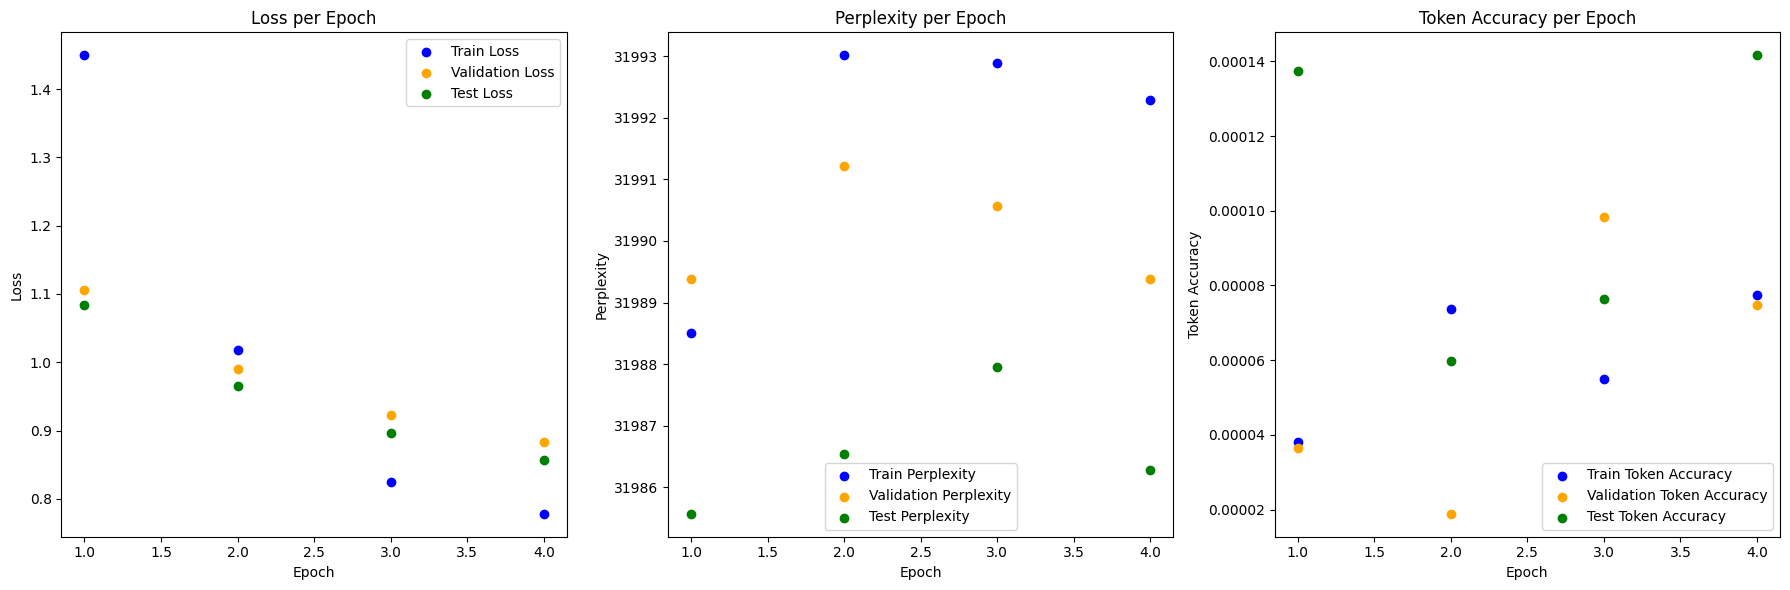

In [46]:
#3. Grafico a dispersione (Scatter Plot)
#Anche se meno comune per questo tipo di dati, un grafico a dispersione può mostrare i punti dati individuali e può essere utile per identificare outlier.
import matplotlib.pyplot as plt

# Estrazione dei dati
epochs = [1, 2, 3, 4]  # Poiché hai solo una singola epoca nei dati forniti

train_loss = log_data["training"]["RISPOSTE"]["loss"]
val_loss = log_data["validation"]["RISPOSTE"]["loss"]
test_loss = log_data["test"]["RISPOSTE"]["loss"]

train_perplexity = log_data["training"]["RISPOSTE"]["perplexity"]
val_perplexity = log_data["validation"]["RISPOSTE"]["perplexity"]
test_perplexity = log_data["test"]["RISPOSTE"]["perplexity"]

train_token_accuracy = log_data["training"]["RISPOSTE"]["token_accuracy"]
val_token_accuracy = log_data["validation"]["RISPOSTE"]["token_accuracy"]
test_token_accuracy = log_data["test"]["RISPOSTE"]["token_accuracy"]

# Creazione del grafico a dispersione
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per la perdita
axs[0].scatter(epochs, train_loss, color='blue', label='Train Loss')
axs[0].scatter(epochs, val_loss, color='orange', label='Validation Loss')
axs[0].scatter(epochs, test_loss, color='green', label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss per Epoch')
axs[0].legend()

# Grafico per la perplessità
axs[1].scatter(epochs, train_perplexity, color='blue', label='Train Perplexity')
axs[1].scatter(epochs, val_perplexity, color='orange', label='Validation Perplexity')
axs[1].scatter(epochs, test_perplexity, color='green', label='Test Perplexity')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].set_title('Perplexity per Epoch')
axs[1].legend()

# Grafico per l'accuratezza dei token
axs[2].scatter(epochs, train_token_accuracy, color='blue', label='Train Token Accuracy')
axs[2].scatter(epochs, val_token_accuracy, color='orange', label='Validation Token Accuracy')
axs[2].scatter(epochs, test_token_accuracy, color='green', label='Test Token Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Token Accuracy')
axs[2].set_title('Token Accuracy per Epoch')
axs[2].legend()

plt.tight_layout()
plt.show()


In [47]:
training_loss = log_data['training']['RISPOSTE']['loss']
validation_loss = log_data['validation']['RISPOSTE']['loss']
next_token_perplexity = log_data['training']['RISPOSTE']['next_token_perplexity']
token_accuracy = log_data['training']['RISPOSTE']['token_accuracy']

# Crea un DataFrame con i dati estratti
df_metrics = pd.DataFrame({
    'epoch': range(1, len(training_loss) + 1),
    'train_loss': training_loss,
    'val_loss': validation_loss,
    'next_token_perplexity': next_token_perplexity,
    'token_accuracy': token_accuracy
})

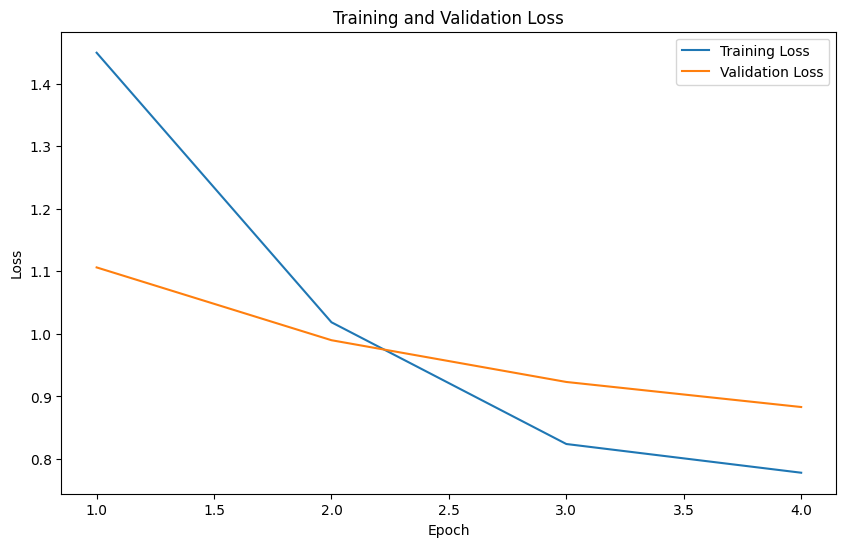

In [48]:
# Traccia i grafici per il training e validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Training Loss')
plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

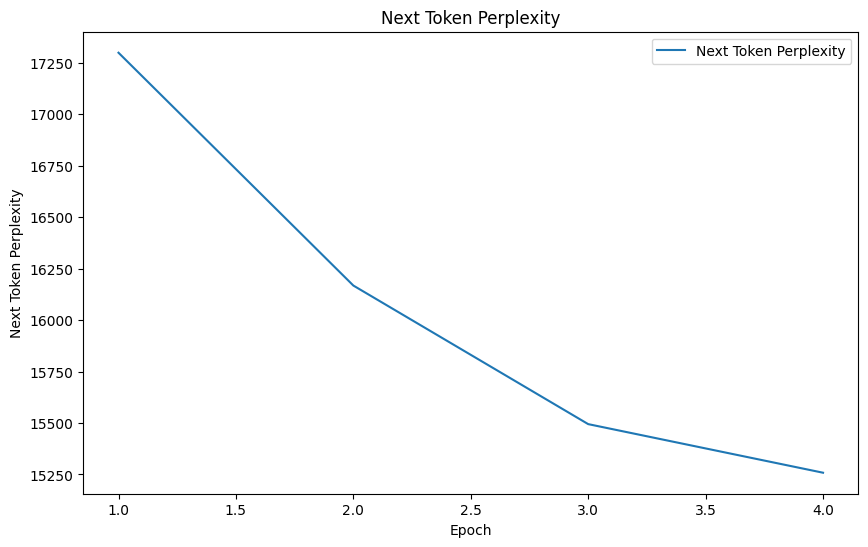

In [49]:
# Grafico per next_token_perplexity
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['epoch'], df_metrics['next_token_perplexity'], label='Next Token Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Next Token Perplexity')
plt.legend()
plt.title('Next Token Perplexity')
plt.show()

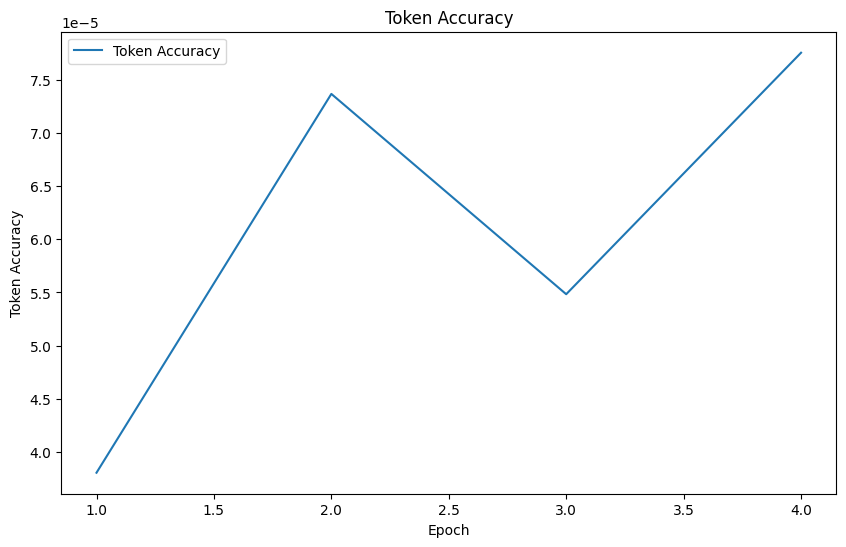

In [50]:
# Grafico per token_accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['epoch'], df_metrics['token_accuracy'], label='Token Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Token Accuracy')
plt.legend()
plt.title('Token Accuracy')
plt.show()

In [51]:
import shutil
from google.colab import files

# Comprimi la directory FineTuned_GPT2_Ludwig in un file zip
shutil.make_archive('FineTuned_Biomistral_Ludwig', 'zip', 'FineTuned_Biomistral_Ludwig')

# Scarica il file zip
files.download('FineTuned_Biomistral_Ludwig.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# Salva i risultati in un nuovo file CSV
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

import shutil

# Percorso del file zip
zip_file = 'results.zip'

# Comprime la cartella 'results'
shutil.make_archive('results', 'zip', 'results')

print(f"Cartella compressa in: {zip_file}")

# Scarica il file zip
files.download(zip_file)

Cartella compressa in: results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#BERT SCORE

**Precision**: Indica la percentuale di parole generate dal modello che sono rilevanti (ovvero, che appaiono anche nella risposta di riferimento). Un valore più alto indica che le risposte generate contengono molte parole corrette.

**Recall**: Indica la percentuale di parole rilevanti che sono state effettivamente generate dal modello. Un valore più alto indica che il modello riesce a coprire bene il contenuto delle risposte di riferimento.

**F1**: È la media armonica di Precision e Recall. Fornisce una misura complessiva dell'accuratezza del modello bilanciando sia Precision che Recall.

## PROVA1:
Mean Precision: 0.7362
Mean Recall: 0.7124
Mean F1: 0.7235